# Plot SWE From Pits 

**Goal**: Plot all the swe as determined from pit density profiles

**Approach**:

1. Grab All the site ids  and loop over them grabbing all the density layers associated
2. Calculate SWE for each layer and sum them up 
3. Convert to a geopandas dataframe
4. plot it!

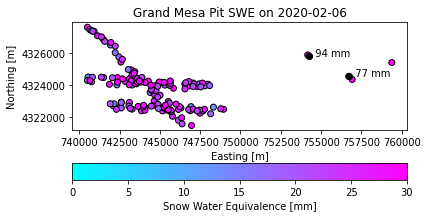

In [3]:
from snowxsql.data import LayerData
from snowxsql.db import get_db
import geopandas as gpd
import matplotlib.pyplot as plt
from geoalchemy2.shape import to_shape

# Connect to the database we made.
db_name = 'postgresql+psycopg2:///snowex'
engine, metadata, session = get_db(db_name)

# Grab all the unique site names
sites = set([s[0] for s in session.query(LayerData.site_id).all()])

# Prepare a dictionary to hold our calculations
d = {'SWE':[], 'geometry':[]}

# Loop over all the sites, grabbing all associated layers and calculate total swe.
for site in sites:

    # Grab all the density layers associated to this site
    layers = session.query(LayerData).filter(LayerData.site_id==site).filter(LayerData.type=='density').all()
    swe = 0
    for l in layers:
        delta = (l.depth - l.bottom_depth) / 1000
        swe += delta * float(l.value)
    d['SWE'].append(swe)
    d['geometry'].append(to_shape(l.geom))

#Convert the dictionary data to a geopandas dataframe
df = gpd.GeoDataFrame(d)

fig, ax = plt.subplots()

# Colorbar keyword arguments
kwds={'label': "Snow Water Equivalence [mm]".format(l.date),'orientation': "horizontal"}

# Plot it all up as a scatter using SWE as the color
ax = df.plot(ax=ax, column='SWE', cmap='cool', vmin=0, vmax=30,  legend=True, legend_kwds=kwds, edgecolor='k')

# Set some style/ labeling choices
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Grand Mesa Pit SWE on {}'.format(l.date))

# Highlight Oddballs SWE Values to have a better colorbar
oddballs = df.nlargest(2, 'SWE')
oddballs['coords'] = oddballs['geometry'].apply(lambda x: x.representative_point().coords[:])
oddballs['coords'] = [coords[0] for coords in oddballs['coords']]

# Plot the odd balls with black and annotate
oddballs.plot(ax=ax, color='k', edgecolor='k')
for idx, row in oddballs.iterrows():
    ax.annotate(s='  {:2.0f} mm'.format(row['SWE']), xy=row['coords'],
                 horizontalalignment='left')